<a href="https://colab.research.google.com/github/schumbar/SJSU_CMPE255/blob/main/assignment_06/g_documents_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMPE256: Assignment 06 - Part G
## Illustrate Document Clustering using LLM Embeddings


Hints:   
1. [LLM Cluster](https://github.com/simonw/llm-cluster)
2. [LLM now provides tools for working with embeddings](https://simonwillison.net/2023/Sep/4/llm-embeddings/#llm-cluster)
3. [Sentence Transformers](https://github.com/UKPLab/sentence-transformers/tree/master/examples/applications/clustering)
4. [How to Cluster Documents Using Word2Vec and K-means](https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/)
5. [Text Clustering](https://github.com/Ruchi2507/Text-Clustering)

Dataset Source:

[BBC News Article Dataset](http://mlg.ucd.ie/datasets/bbc.html)

Dataset Citation:
- D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.

Sources Used:
1. ChatGPT-4
2. All listed hints

### Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install matplotlib
!pip install seaborn
!pip install transformers
!pip install nltk
!pip install gensim

In [3]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import seaborn as sns

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
dataset_file = '/content/drive/MyDrive/Colab Notebooks/CMPE255/assignment_06/part_g/g_words.csv'

#### Already Done: Converting data into .csv file

In [5]:
# import os

# def get_all_text(data_dir):
#     # Initialize an empty list to store the text data
#     text_data = []

#     # Iterate through each subdirectory (business, entertainment, politics, sport, tech)
#     for category_folder in os.listdir(data_dir):
#         category_path = os.path.join(data_dir, category_folder)

#         # Check if it's a directory
#         if os.path.isdir(category_path):

#             # Iterate through the .txt files in the category folder
#             for filename in os.listdir(category_path):
#                 if filename.endswith('.txt'):
#                     file_path = os.path.join(category_path, filename)

#                     # Read the text from the file
#                     with open(file_path, 'r', encoding='utf-8') as file:
#                         text = file.read()
#                         text_data.append((category_folder, text))  # Store category and text together

#     return text_data

# def get_category(text_data):
#     return text_data[0][0]

# def get_text(text_data):
#     return text_data[0][1]

# # Example usage:
# data_dir = dataset_folder_path
# all_text_data = get_all_text(data_dir)

# # Get the category and text for the first document
# category = get_category(all_text_data[0])
# text = get_text(all_text_data[0])

# print("Category:", category)
# print("Text:", text)


In [6]:
# Function to clean text data
def clean_text(text):
    """
    Function to clean the text data. This includes:
    - Lowercasing the text
    - Removing special characters and numbers
    - Stripping extra white spaces
    """
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text)  # Remove extra white spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and special characters
    return text.strip()

In [7]:
# Function to tokenize and remove stopwords
def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    return [word for word in tokens if word not in stop_words]

In [8]:
# Function to create a document embedding by averaging word embeddings
def document_embedding(tokens, model):
    valid_tokens = [token for token in tokens if token in model.wv.key_to_index]
    if not valid_tokens:
        return np.zeros(model.vector_size)
    embeddings = [model.wv[token] for token in valid_tokens]
    return np.mean(embeddings, axis=0)

### Loading the Data

In [9]:
# Load the dataset
file_path = dataset_file
data = pd.read_csv(file_path)

### Data Preprocessing and Cleaning

In [10]:
# Apply text cleaning to the dataset
data['Cleaned_Text'] = data['Text'].apply(clean_text)

In [11]:
# Get English stopwords
stop_words = set(stopwords.words('english'))

In [12]:
# Apply tokenization and stopword removal to the dataset
data['Tokens'] = data['Cleaned_Text'].apply(tokenize_and_remove_stopwords)

In [13]:
# Selecting 30 articles from each category
subset_data = data.groupby('Category').apply(lambda x: x.sample(n=30, random_state=1)).reset_index(drop=True)

### EDA

In [14]:
# Calculate the average length of articles in each category
subset_data['Article_Length'] = subset_data['Tokens'].apply(len)
average_length_per_category = subset_data.groupby('Category')['Article_Length'].mean()

In [15]:
# Find the most common words in each category
most_common_words = {}
for category in subset_data['Category'].unique():
    words = [word for tokens in subset_data[subset_data['Category'] == category]['Tokens'] for word in tokens]
    word_counts = Counter(words)
    most_common_words[category] = word_counts.most_common(10)

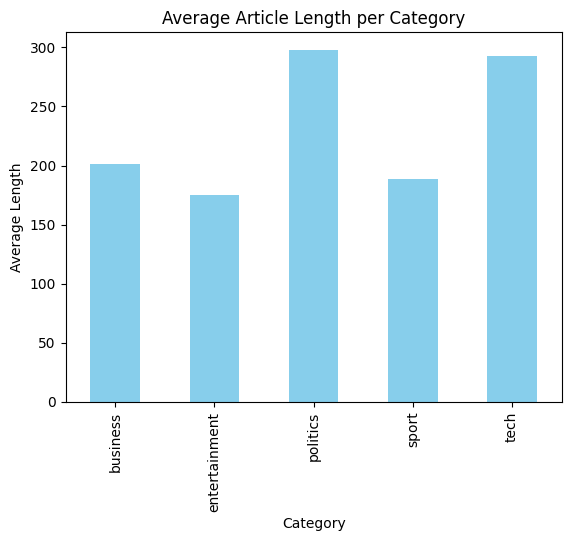

In [16]:
# Display the average article length per category
average_length_per_category.plot(kind='bar', color='skyblue')
plt.title('Average Article Length per Category')
plt.ylabel('Average Length')
plt.xlabel('Category')
plt.show()

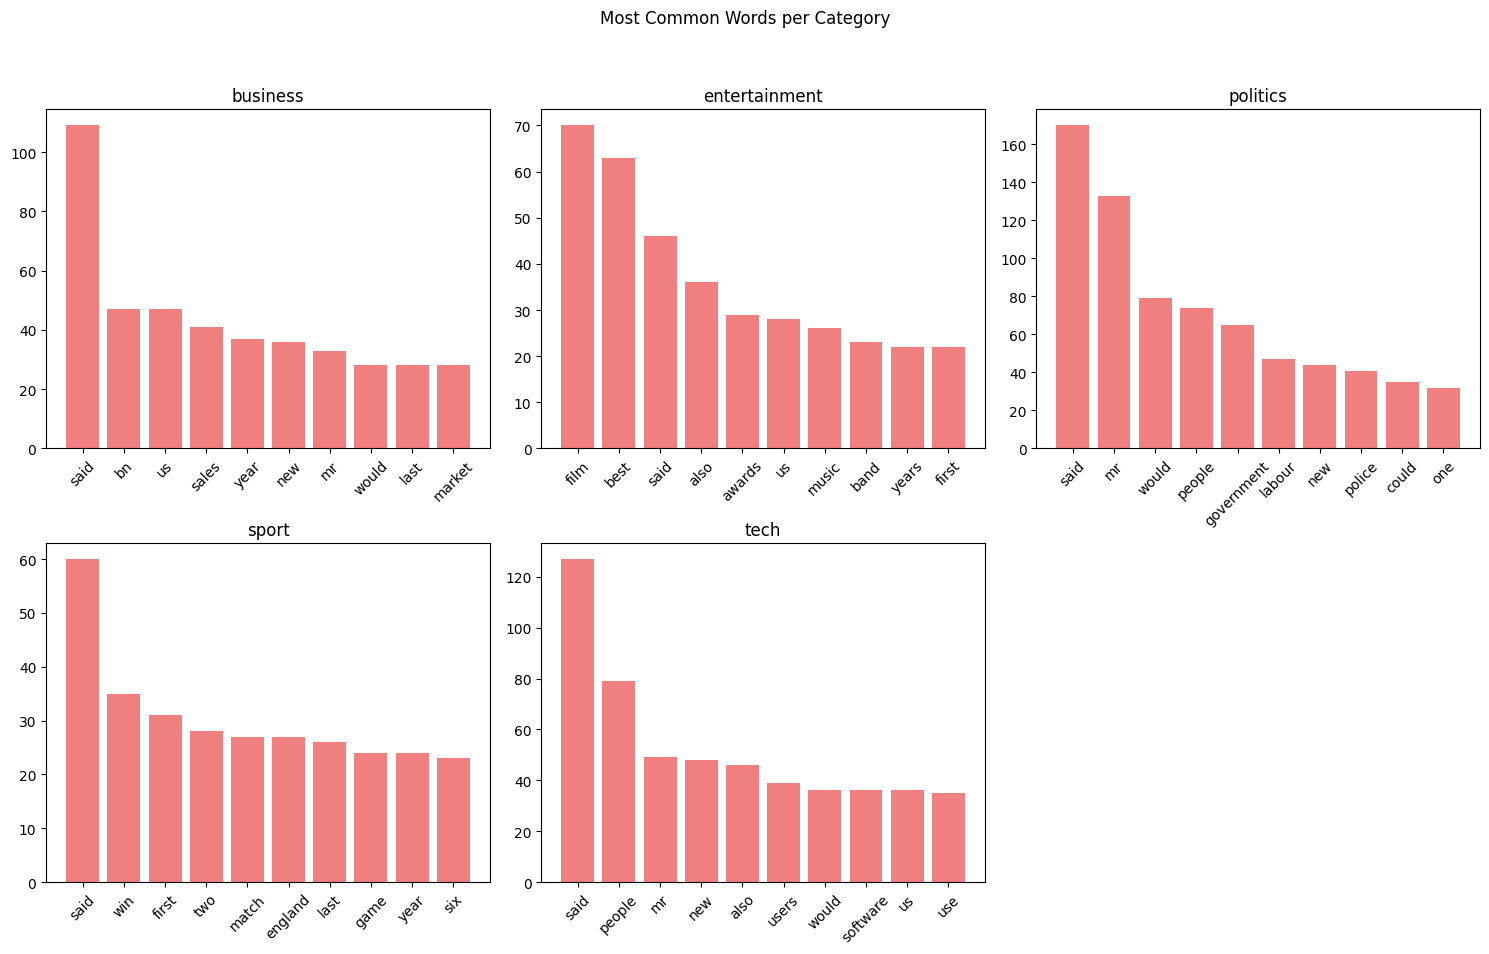

In [17]:
# Display the most common words per category
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Most Common Words per Category')
axes = axes.flatten()

for i, category in enumerate(most_common_words.keys()):
    words, counts = zip(*most_common_words[category])
    axes[i].bar(words, counts, color='lightcoral')
    axes[i].set_title(category)
    axes[i].tick_params(axis='x', rotation=45)

# Hide the last empty subplot (if any)
if len(most_common_words.keys()) < len(axes):
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Data Subset Analysis Results
1. **Average Article Length per Category**: The bar chart shows the average length of articles in each category. This provides insight into how verbose or concise articles are in different categories.

2. **Most Common Words per Category**: The bar charts for each category display the top 10 most common words. This can reveal the focus or thematic elements prevalent in each category.

### Training Word2Vec Model

We will now move on to implementing Word2Vec embedding for the text data. This involves:

1. **Training the Word2Vec Model**: We'll train a Word2Vec model using the tokens from our dataset.
2. **Generating Document Embeddings**: We will use the trained model to generate embeddings for each document (news article) by averaging the embeddings of the words in the article.

In [18]:
# Preparing the tokenized data for Word2Vec training
tokenized_data = subset_data['Tokens'].tolist()

# Define and train the Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_data, vector_size=100, window=5, min_count=1, workers=2)

In [19]:
# Apply the function to create document embeddings
subset_data['Doc_Embedding'] = subset_data['Tokens'].apply(lambda x: document_embedding(x, word2vec_model))

In [20]:
# Preparing the embeddings for clustering
embeddings = np.array(subset_data['Doc_Embedding'].tolist())

### Document Clustering
We will now apply the K-Means text clustering algorithm to cluster the news articles. The process will involve:

1. **Choosing the Number of Clusters**: Determining the optimal number of clusters for K-Means.
2. **Applying K-Means Clustering**: Using the document embeddings to perform clustering.
3. **Assigning Clusters to Data**: Associating each article with its respective cluster.

In [21]:
# Applying K-Means Clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(embeddings)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=1)

In [22]:
# Assigning cluster labels to each article
subset_data['Cluster'] = kmeans.labels_

In [23]:
# Calculating inertia to evaluate clustering quality
inertia = kmeans.inertia_

In [24]:
# Using PCA for dimensionality reduction to 2D for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

In [25]:
# Creating a DataFrame for visualization
vis_df = pd.DataFrame(reduced_embeddings, columns=['PCA1', 'PCA2'])
vis_df['Cluster'] = subset_data['Cluster']
vis_df['Category'] = subset_data['Category']


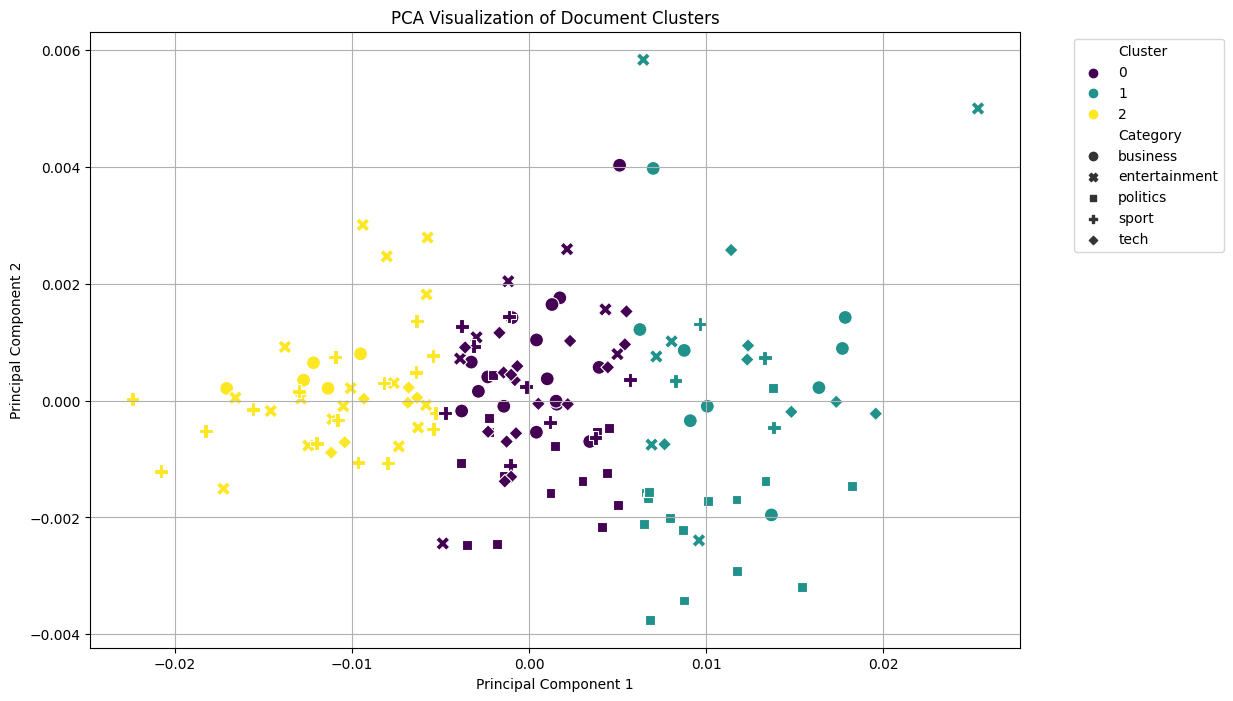

In [26]:
# Plotting the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=vis_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', style='Category', markers=True, s=100)
plt.title('PCA Visualization of Document Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

### Conclusion of Document Clustering Analysis

1. **Dataset and Preprocessing:** We worked with a dataset of news articles categorized into business, entertainment, politics, sport, and tech. The preprocessing involved cleaning the text and tokenizing it, making it suitable for analysis.

2. **Word2Vec Embeddings:** We successfully applied Word2Vec to create embeddings for each document, capturing the semantic essence of the articles in vector form.

3. **K-Means Clustering:** Using the K-Means algorithm with 3 clusters, we clustered the articles based on their embeddings. The clusters formed represent groupings of articles with similar content themes.

4. **Evaluation and Visualization:** The clustering quality was evaluated using metrics like inertia and silhouette score. The PCA visualization provided a clear view of how these articles grouped together in the reduced dimensional space, showing distinct clusters.

5. **Insights:** The clustering seemed to reasonably group articles, though some overlap was observed. This is expected as news articles can have overlapping themes or multidisciplinary content.

6. **Applications:** This analysis is valuable for organizing large sets of documents, enhancing content recommendation systems, and improving information retrieval in databases.

7. **Future Work:** Further improvements could include experimenting with different preprocessing steps, using more sophisticated dimensionality reduction techniques like t-SNE, or trying different clustering algorithms.

